In [10]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from PIL import ImageFilter
from scipy import ndimage
import cv2

import cPickle

from sklearn import linear_model, datasets

%matplotlib inline
one=cv2.imread("Images/Q2/Working set/I1.jpg")
two=cv2.imread("Images/Q2/Working set/I2.jpg")
three=cv2.imread("Images/Q2/Working set/I3.jpg")
# one = np.asarray(Image.open("Images/Q2/Working set/I1.jpg"),dtype=np.float64)/255.0
# two = np.asarray(Image.open("Images/Q2/Working set/I2.jpg"),dtype=np.float64)/255.0
# three = np.asarray(Image.open("Images/Q2/Working set/I3.jpg"),dtype=np.float64)/255.0


In [23]:
def extract_features(img):
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    brisk=cv2.BRISK()
    kps,descs=brisk.detectAndCompute(gray,None)
    return (kps,descs)

def find_matches(des1,des2):
    FLANN_INDEX_KDTREE=0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    return matches

def good_matches(matches):
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    return good

kps1,descs1=extract_features(one)
kps2,descs2=extract_features(two)
# matches1=find_matches(descs1,descs2)
# print(good_matches(matches1))

In [21]:
sift = cv2.BRISK()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(one,None)
kp2, des2 = sift.detectAndCompute(two,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


error: /build/buildd/opencv-2.4.9+dfsg/modules/flann/src/miniflann.cpp:315: error: (-210) type=0
 in function buildIndex_


/home/brendan/.local/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


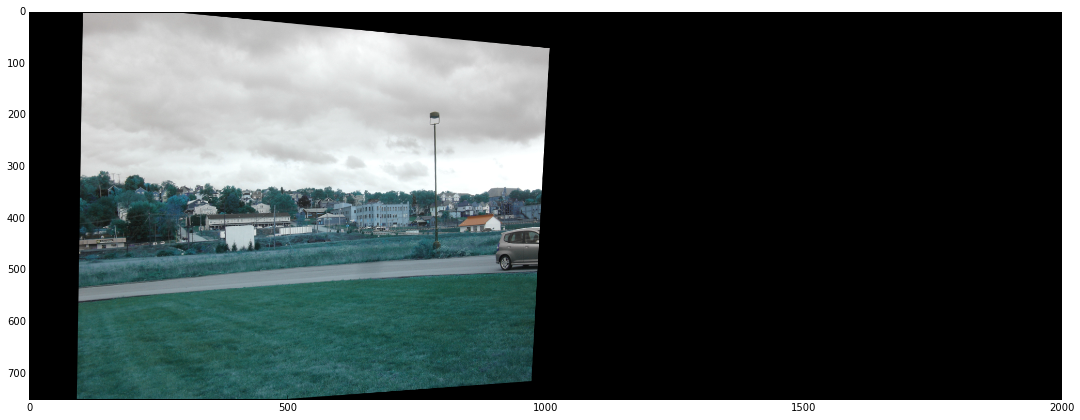

In [110]:
matcher = cv2.DescriptorMatcher_create("BruteForce")
rawMatches = matcher.knnMatch(descs1, descs2, 2)
matches = []
# loop over the raw matches
for m in rawMatches:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe's ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * .75:
        matches.append((m[0].trainIdx, m[0].queryIdx))
ptsA = np.float32([kp1[i].pt for (_, i) in matches])
ptsB = np.float32([kp2[i].pt for (i, _) in matches])
(H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
    3)

ones=np.array([1,1,1])
x_shift=abs(np.dot(H,ones)[0])
trans=np.array([[1,0,x_shift],[0,1,0],[0,0,1]])
result = cv2.warpPerspective(one, np.dot(H,trans),(one.shape[1] + two.shape[1], one.shape[0]))
warp1=result.copy()
result[0:two.shape[0], x_shift:two.shape[1]+x_shift] = two



# result = cv2.warpPerspective(one, H,(one.shape[1] + two.shape[1], one.shape[0]))

# print(result.shape)
# shifted_two=np.concatenate((np.zeros((750,1000,3)),two),axis=1)
# result+=shifted_two
f2=plt.figure()
f2.set_size_inches(18.5, 10.5)
plt.imshow(warp1)



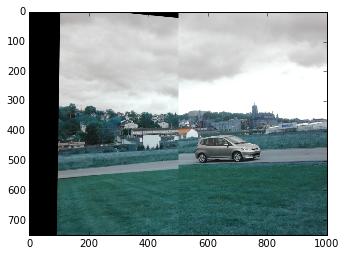

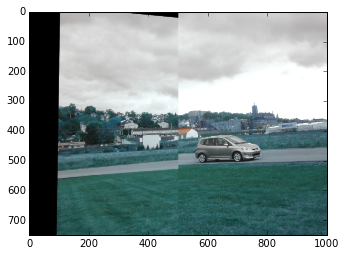

In [142]:
A=warp1.copy()
B=two.copy()

n=2
G = A.copy()
gpA = [G]
for i in xrange(n):
    G = cv2.pyrDown(G)
    gpA.append(G)

# generate Gaussian pyramid for B
G = B.copy()
gpB = [G]
for i in xrange(n):
    G = cv2.pyrDown(G)
    gpB.append(G)

# generate Laplacian Pyramid for A
lpA = [gpA[n-1]]
for i in xrange(n-1,0,-1):
    GE = cv2.pyrUp(gpA[i])
    L = cv2.subtract(gpA[i-1],GE)
    lpA.append(L)

# generate Laplacian Pyramid for B
lpB = [gpB[n-1]]
for i in xrange(n-1,0,-1):
    GE = cv2.pyrUp(gpB[i])
    L = cv2.subtract(gpB[i-1],GE)
    lpB.append(L)

    
# Now add left and right halves of images in each level
LS = []
for la,lb in zip(lpA,lpB):
    rows,cols,dpt = la.shape
    ls = np.hstack((la[:,0:cols/4], lb[:,cols/4:]))
    LS.append(ls)

# now reconstruct
ls_ = LS[0]
for i in xrange(1,n):
    ls_ = cv2.pyrUp(ls_)
    ls_ = cv2.add(ls_, LS[i])

# image with direct connecting each half
real = np.hstack((A[:,:cols/4],B[:,cols/4:]))
plt.figure()
plt.imshow(real)
plt.figure()
plt.imshow(ls_)